In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from cylindrical_plasma import CylindricalPlasma, PlasmaDrawable
from detector import Detector, DetectorDrawable
from utils import iter_to_str
from math_utils import Vector3D, EPSILON, dist


# Задание параметров детекторов

In [2]:
d = {'center': (-1.5, -1.5, 0.0), 'rows': 1, 'cols': 1, 'color': 'green' ,'filename': 'd.txt'}
d_left = {'center': (-1.48, -1.515, 0.0), 'rows': 1, 'cols': 1, 'color': 'blue','filename': 'd_left.txt'}
d_right = {'center': (-1.52, -1.483, 0.0), 'rows': 1, 'cols': 1, 'color': 'black','filename': 'd_right.txt'}
d_up = {'center': (-1.49, -1.49, -0.02), 'rows': 1, 'cols': 1, 'color': 'blue','filename': 'd_up.txt'}
d_down = {'center': (-1.49, -1.49, 0.02), 'rows': 1, 'cols': 1, 'color': 'black','filename': 'd_down.txt'}


# Вспомогательные функции

In [3]:
def plot(detectors, filename):
    plasma = PlasmaDrawable(r_min=0.0, r_max=1.0, z_min=-1.0, z_max=1.0)
    plasma.build_segmentation(n_r=2, n_phi=4, n_z=2)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
#     ax.set_title('Example plot')
    plasma.plot(ax, color='red')
    for detector in detectors:
        d = DetectorDrawable(center=detector["center"], aperture=(-1.1, -1.0, 0.0), height=0.6, width=0.6)
        d.set_pixels(rows=detector['rows'], cols=detector['cols'])
        d.plot(ax, lines_length=d.lines_length_calculate(plasma), color=detector['color'])
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
def generate_file(plasma, detector, filename):
    """ Generates data-file for given plasma and detector. """
    # Ax = b
    A = detector.build_chord_matrix(plasma)
    x = plasma.solution
    b = detector.right_part(plasma)
    assert dist(A.dot(x), b) < EPSILON

    # generating full name of file
    try:
        with open(filename, 'w') as file:
            # writing x, b and A into file, separated by one blank line
            file.write(iter_to_str(x) + '\n\n')
            file.write(iter_to_str(b) + '\n\n')
            for row in A:
                file.write(iter_to_str(row) + '\n')
            # writing geometry of plasma and detector after blank line
            file.write('\n' + plasma.__repr__() + '\n')
            file.write(detector.__repr__() + '\n')
    except IOError as error:
        print(error)

def create_datafiles(detectors):
    r_min = 0.0
    r_max = 1.0
    z_min = -1.0
    z_max = 1.0
    n_r = 6
    n_phi = 6
    n_z = 6
    phi_0 = 3.6411293856408307  # (~ pi + 1/2)
    lum_cor = 0
    lum_nuc = 1

    # detector metrics
    aperture = -1.1, -1.0, 0.0  # position of detector's aperture
    # Detector's matrix is the rectangle with sides of size 'height' and 'width'.
    height = 0.6
    width = 0.6
    # The detector's matrix could be rotated around its normal by 'angle'.
    angle = 0.0
    # Detector will have 'rows' lines of pixels, each line contains 'cols' pixels.
    rows = 16
    cols = 16

    # creating plasma with given metrics
    plasma = CylindricalPlasma(r_min=r_min, r_max=r_max, z_min=z_min, z_max=z_max)
    # dividing plasma into segments (by default plasma is one big segment)
    plasma.build_segmentation(n_r=n_r, n_phi=n_phi, n_z=n_z)
    # rotating plasma (and all its segments) by given angle around 'Z' axis
    plasma.rotate(phi_0)
    # assigning gradient luminosity to each segment
    plasma.lum_gradient(lum_cor=lum_cor, lum_nuc=lum_nuc)
    
    for d in detectors:
        # creating detector with given metrics
        detector = Detector(center=d['center'], aperture=aperture, height=height, width=width, angle=angle)
        # setting given amount of pixels on detector (by default detector has one pixel at the center)
        detector.set_pixels(rows=rows, cols=cols)
        # generating data-file with specified geometry
        generate_file(plasma=plasma, detector=detector, filename='examples/gradient_'+d['filename'])


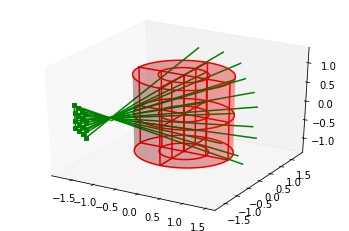

In [4]:
det = {'center': (-1.5, -1.5, 0.0), 'rows': 4, 'cols': 4, 'color': 'green' ,'filename': 'd.txt'}
plot([det], 'детектор')

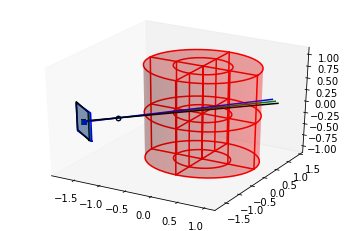

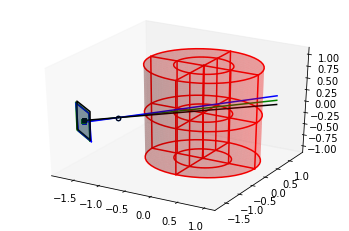

In [5]:
plot([d, d_left, d_right], 'left_right_rotation')
plot([d, d_up, d_down], 'up_down_rotation')

# Создание файлов

In [6]:
create_datafiles([d_left, d_right, d_up, d_down])

In [7]:
detectors = [d_left, d_right, d_up, d_down]

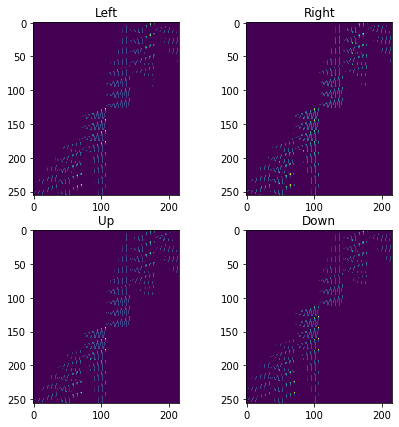

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
matrixies = []

matrix = np.loadtxt('./matrix/gradient_'+d_left['filename'])
ax[0][0].imshow(matrix)
ax[0][0].set_title('Left')
matrixies.append(matrix)

matrix = np.loadtxt('./matrix/gradient_'+d_right['filename'])
ax[0][1].imshow(matrix)
ax[0][1].set_title('Right')
matrixies.append(matrix)

matrix = np.loadtxt('./matrix/gradient_'+d_up['filename'])
ax[1][0].imshow(matrix)
ax[1][0].set_title('Up')
matrixies.append(matrix)

matrix = np.loadtxt('./matrix/gradient_'+d_down['filename'])
ax[1][1].imshow(matrix)
ax[1][1].set_title('Down')
matrixies.append(matrix)

plt.savefig('4_mtrx')

In [9]:
# возьмем inf и sup от получившихся 4 матриц
matrixies = np.array(matrixies)
p, n, m = matrixies.shape
inf_matrix = np.zeros(shape=[n, m], dtype=float)
sup_matrix = np.zeros(shape=[n, m], dtype=float)
inf_matrix.shape
for i in range(n):
    for j in range(m):
        inf_matrix[i][j] = min(matrixies[0][i][j], matrixies[1][i][j], matrixies[2][i][j], matrixies[3][i][j])
        sup_matrix[i][j] = max(matrixies[0][i][j], matrixies[1][i][j], matrixies[2][i][j], matrixies[3][i][j])
    

# Решение задачи субдифференциальным методом Ньютона

In [10]:
from kaucherpy_master.src.kaucher.Kaucher import *
from subDiff import subdiff2

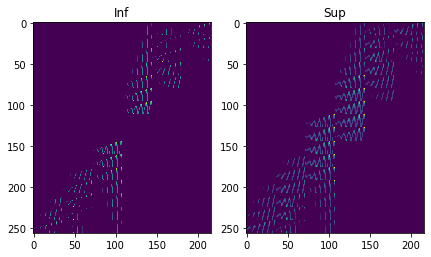

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax[0].imshow(inf_matrix)
ax[0].set_title('Inf')

ax[1].imshow(sup_matrix)
ax[1].set_title('Sup')


plt.savefig('inf_sup_mtrx')

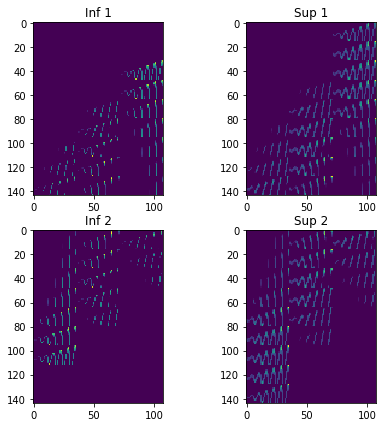

In [12]:
# разделим на две подматрицы и изобразим их
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

inf_matrix1 = inf_matrix[112:, 0:108]
sup_matrix1 = sup_matrix[112:, 0:108]

inf_matrix2 = inf_matrix[:-112, 108:]
sup_matrix2 = sup_matrix[:-112, 108:]

ax[0][0].imshow(inf_matrix1)
ax[0][0].set_title('Inf 1')

ax[0][1].imshow(sup_matrix1)
ax[0][1].set_title('Sup 1')

ax[1][0].imshow(inf_matrix2)
ax[1][0].set_title('Inf 2')

ax[1][1].imshow(sup_matrix2)
ax[1][1].set_title('Sup 2')

plt.savefig('inf_sup_mtrx_1_2')

# Вспомогательные функции

In [13]:
def find_matrix_interval(inf_matrix, sup_matrix, size):
    n = len(inf_matrix)
    m = len(inf_matrix[0])
    size = min(n, m, size)
    k = 0
    while size > 0:
        print('cur_size = ', size)
        s = 0
        k += 1
        for i in range(n - size + 1):
            s = 0
            for j in range(m - size + 1):
                s = 0
                det1 = np.linalg.det(inf_matrix[i:i+size, j:j+size])
                det2 = np.linalg.det(sup_matrix[i:i+size, j:j+size])
                det1, det2 = min(det1, det2), max(det1, det2)
                if not(det1 <= 0 <= det2):
                    print(j)
                    break
                s+=1
            if s == 0:
                break
        if s == 0:
            break
        size -=1
    return i, j, size

в результате:

for matrix1 18 82 14

for matrix2 114 10 14

In [14]:
def get_b(inf_matrix, sup_matrix, x, n):
    mtx_interval = [[Kaucher(inf_matrix[i,j], sup_matrix[i,j]) 
                     for j in range(n)] for i in range(n)]
    
    x_interval = [Kaucher(x[i], x[i]) for i in range(n)]
    b_interval = [sum([mtx_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    b_inf, b_sup = np.zeros(shape=n), np.zeros(shape=n)
    for j in range(n):
        b_inf[j] = b_interval[j].lower
        b_sup[j] = b_interval[j].upper
    return b_inf, b_sup

# Графики

In [20]:
def plot_solution(mtx_inf, mtx_sup, x_inf, x_sup, x_real, inf_b, sup_b, filename = None):
    n = mtx_inf.shape[0]
    mtx_interval = [[Kaucher(mtx_inf[i,j], mtx_sup[i,j]) for j in range(n)] for i in range(n)]
    x_interval = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]
    b_interval = [sum([mtx_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    inf_b_sol = np.array([comp.lower for comp in b_interval])
    sup_b_sol = np.array([comp.upper for comp in b_interval])
    plt.plot(inf_b, label='inf(b)')
    plt.plot(sup_b, label='sup(b)')
    
    plt.plot(inf_b_sol, label='inf(Ax_sol)', linestyle='--')
    plt.plot(sup_b_sol, label='sup(Ax_sol)', linestyle='--')
    
    x_interval = [Kaucher(x_real[i], x_real[i]) for i in range(n)]
    Ax_real = [sum([mtx_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    inf_Ax_real = np.array([comp.lower for comp in b_interval])
    sup_Ax_real = np.array([comp.upper for comp in b_interval])
    
#     plt.plot(mid_Ax, label='mid(Ax)')
    plt.plot(inf_b_sol, label='inf(Ax_real)', linestyle='--')
    plt.plot(sup_b_sol, label='sup(Ax_real)', linestyle='--')
    plt.legend()
    if filename is not None:
        plt.savefig('plot_solution' + filename)
    plt.show()
    plt.close()
    
def plot_real_vs_solve(x_real, x_inf, x_sup, filename = None):
    plt.plot(x_real, marker='o', label='real solution')
    plt.plot(x_inf,label='inf')
    plt.plot(x_sup, label='sup')
    plt.legend()
    if filename is not None:
        plt.savefig('plot_real_vs_solve' + filename)
    plt.show()
    plt.close()
       

In [21]:
def experiment(inf_matrix, sup_matrix, x_real, param=None, filename=None):
    if param is None:
        i, j, size = find_matrix_interval(inf_matrix, sup_matrix, 20)
    else:
        i, j, size = param
        
    inf_matrix = inf_matrix[i:i+size, j:j+size]
    sup_matrix = sup_matrix[i:i+size, j:j+size]
    x_real = x_real[j:j+size]
    b_inf, b_sup = get_b(inf_matrix, sup_matrix, x_real, size)
    
    (x_inf, x_sup), x_seq, cur_iter, norm_list = subdiff2(inf_matrix, sup_matrix, b_inf, b_sup)
    plot_solution(inf_matrix, sup_matrix, x_inf, x_sup, x_real, b_inf, b_sup, filename)
    plot_real_vs_solve(x_real, x_inf, x_sup, filename)


In [17]:
x_real = np.loadtxt('./matrix/s216.txt')
x1 = x_real[:108]
x2 = x_real[108:]

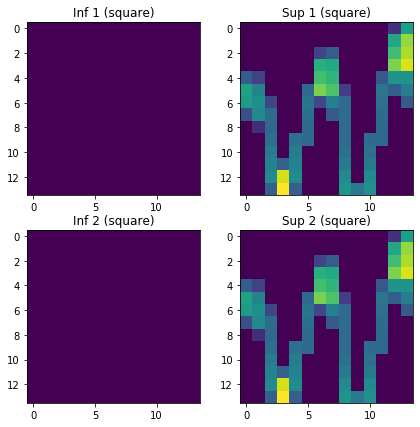

In [26]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

i, j, size = 18,  82,14
ax[0][0].imshow(inf_matrix1[i:i+size, j:j+size])
ax[0][0].set_title('Inf 1 (square)')

ax[0][1].imshow(sup_matrix1[i:i+size, j:j+size])
ax[0][1].set_title('Sup 1 (square)')

i, j, size = 114, 10, 14
ax[1][0].imshow(inf_matrix2[i:i+size, j:j+size])
ax[1][0].set_title('Inf 2 (square)')

ax[1][1].imshow(sup_matrix2[i:i+size, j:j+size])
ax[1][1].set_title('Sup 2 (square)')

plt.savefig('square_inf_sup_mtrx_1_2')

(144, 108) (144, 108) (108,)


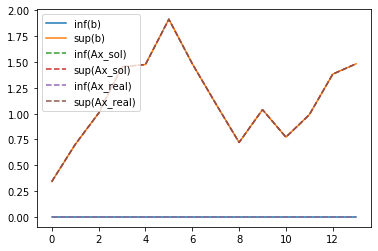

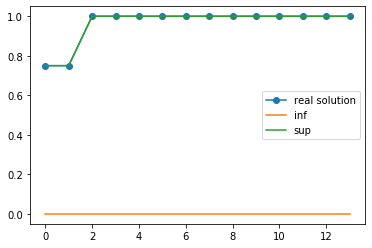

In [24]:
i, j, size = 18,  82,14
experiment(inf_matrix1, sup_matrix1, x1, (i, j, size), filename='_matrix1')

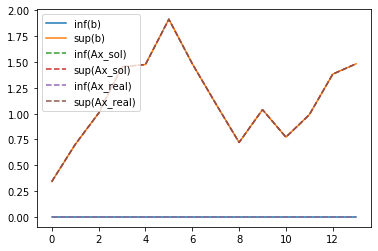

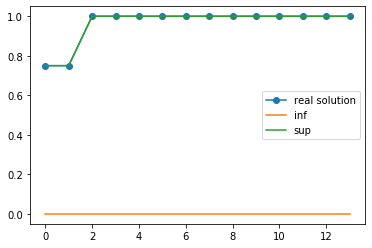

In [25]:
i, j, size = 114, 10, 14
experiment(inf_matrix2, sup_matrix2, x2, (i, j, size), filename='_matrix2')